# UFC Data Analysis Notebook


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
stats = pd.read_csv('data.csv')
odds = pd.read_csv('UFC_betting_odds.csv')

/tmp/ipykernel_506118/2884420061.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  odds = pd.read_csv('UFC_betting_odds.csv')


In [9]:
print('Stats shape:', stats.shape)
print('Odds shape:', odds.shape)

Stats shape: (6012, 144)
Odds shape: (109924, 17)


In [10]:
stats['pair'] = (
    stats['R_fighter'].str.strip().str.lower() + '_' +
    stats['B_fighter'].str.strip().str.lower()
)

# Odds uses fighter_1 and fighter_2
odds['pair'] = (
    odds['fighter_1'].str.strip().str.lower() + '_' +
    odds['fighter_2'].str.strip().str.lower()
)

merged = stats.merge(
    odds[['pair','odds_1','odds_2']],
    on='pair',
    how='inner'
)

print("Merged shape:", merged.shape)
merged.head()

Merged shape: (5086, 147)


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,pair,odds_1,odds_2
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,Orthodox,170.18,177.80,135.0,31.0,27.0,adrian yanez_gustavo lopez,1.465116,2.780000
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,Orthodox,182.88,187.96,185.0,32.0,28.0,trevin giles_roman dolidze,1.869565,1.952381
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,0,Southpaw,187.96,190.50,264.0,32.0,28.0,tai tuivasa_harry hunsucker,1.232558,4.450000
3,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,0,Orthodox,167.64,172.72,135.0,29.0,43.0,marion reneau_macy chiasson,2.850000,1.444444
4,Leonardo Santos,Grant Dawson,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,Lightweight,0.000,0.0,...,0,Orthodox,182.88,190.50,155.0,27.0,41.0,leonardo santos_grant dawson,2.600000,1.540541


In [11]:
merged['favorite_prob'] = 1 / merged[['odds_1','odds_2']].min(axis=1)

merged['favorite_won'] = np.where(
    (merged['odds_1'] < merged['odds_2']) & (merged['Winner'] == 'Red'), 1,
    np.where((merged['odds_2'] < merged['odds_1']) & (merged['Winner'] == 'Blue'), 1, 0)
)


In [12]:
weight_map = {
    'Flyweight': 125,
    'Bantamweight': 135,
    'Featherweight': 145,
    'Lightweight': 155,
    'Welterweight': 170,
    'Middleweight': 185,
    'LightHeavyweight': 205,
    'Heavyweight': 265,
    'WomenStrawweight': 115,
    'WomenFlyweight': 125,
    'WomenBantamweight': 135,
    'WomenFeatherweight': 145
}

merged['weight_num'] = merged['weight_class'].map(weight_map)
print(merged[['weight_class','weight_num']].head(15))


         weight_class  weight_num
0        Bantamweight       135.0
1        Middleweight       185.0
2         Heavyweight       265.0
3   WomenBantamweight       135.0
4         Lightweight       155.0
5        Welterweight       170.0
6        Middleweight       185.0
7        Bantamweight       135.0
8           Flyweight       125.0
9           Flyweight       125.0
10   LightHeavyweight       205.0
11       Welterweight       170.0
12      Featherweight       145.0
13       Middleweight       185.0
14   WomenStrawweight       115.0


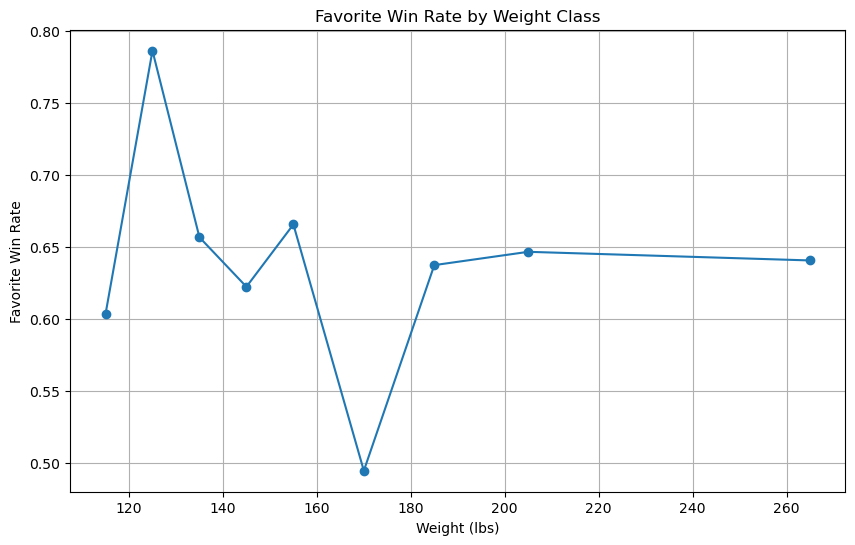

In [13]:
# VISUAL 1
predict = merged.groupby('weight_num')['favorite_won'].mean()

plt.figure(figsize=(10,6))
plt.plot(predict.index, predict.values, marker='o')
plt.title('Favorite Win Rate by Weight Class')
plt.xlabel('Weight (lbs)')
plt.ylabel('Favorite Win Rate')
plt.grid()
plt.show()

/tmp/ipykernel_506118/2310302165.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_plot = merged.groupby('prob_bin')['favorite_won'].mean()


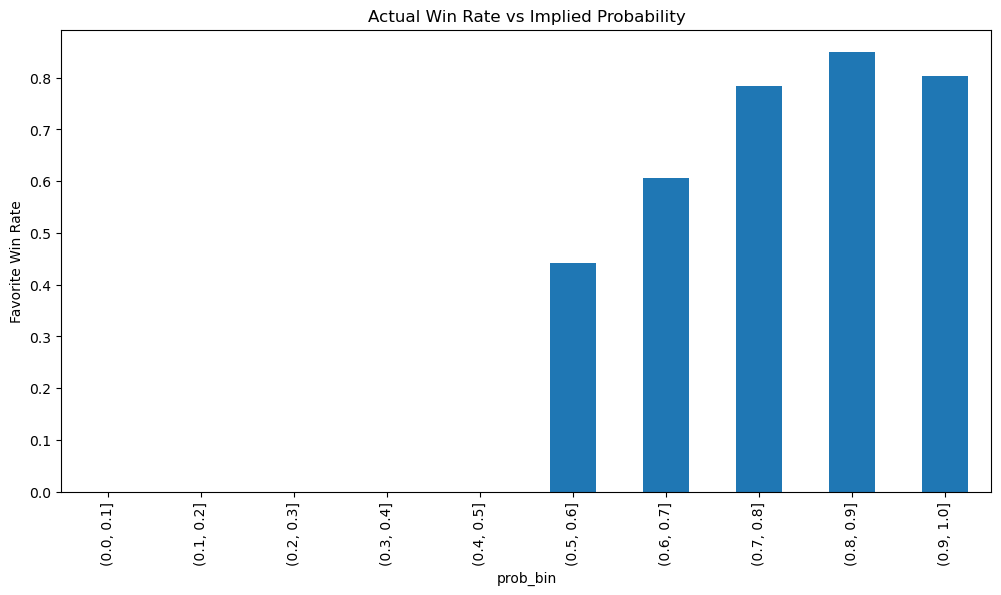

In [14]:
# VISUAL 2
bins = np.linspace(0, 1, 11)
merged['prob_bin'] = pd.cut(merged['favorite_prob'], bins)

prob_plot = merged.groupby('prob_bin')['favorite_won'].mean()

plt.figure(figsize=(12,6))
prob_plot.plot(kind='bar')
plt.title('Actual Win Rate vs Implied Probability')
plt.ylabel('Favorite Win Rate')
plt.show()

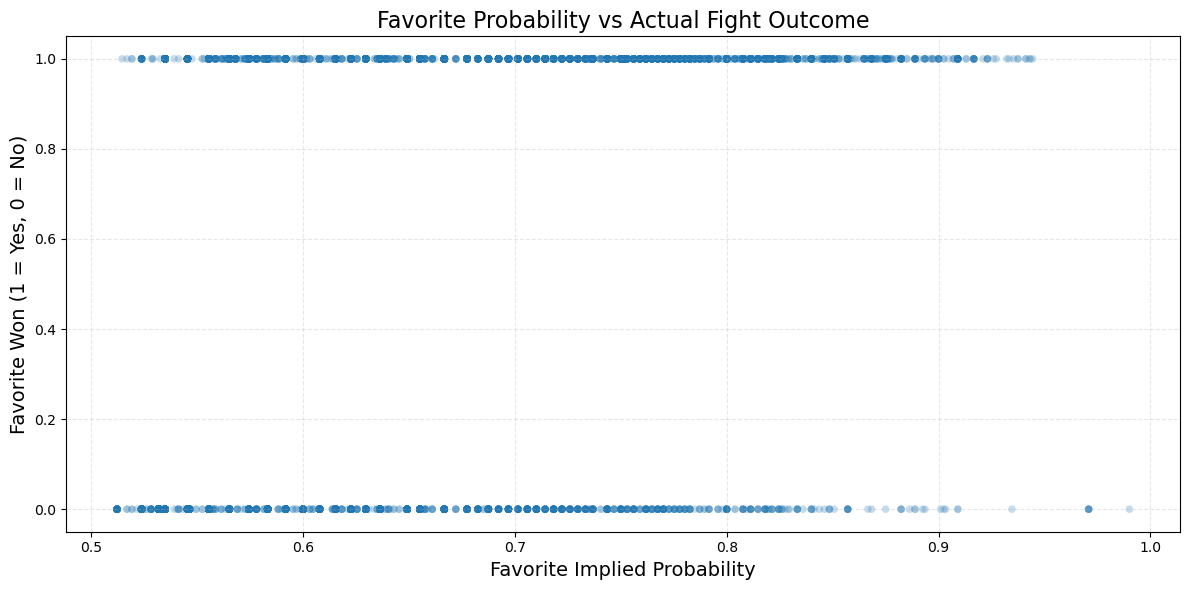

In [20]:
# VISUAL 2
plt.figure(figsize=(12,6))
plt.scatter(
    merged['favorite_prob'],
    merged['favorite_won'],
    alpha=0.25,
    s=30,
    edgecolor='none'
)

plt.title('Favorite Probability vs Actual Fight Outcome', fontsize=16)
plt.xlabel('Favorite Implied Probability', fontsize=14)
plt.ylabel('Favorite Won (1 = Yes, 0 = No)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()